<a href="https://colab.research.google.com/github/AnirudhJM24/myML/blob/main/anomaliez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [70]:
df = pd.read_csv("c.csv")
df.head()

,date,l_ipn,r_asn,f
0,2006-07-01,0,701,1
1,2006-07-01,0,714,1
2,2006-07-01,0,1239,1
3,2006-07-01,0,1680,1
4,2006-07-01,0,2514,1


The days on which suspicious activity was detected 


(date vs ip)

> 08-24 : 1

> 09-04 : 5

> 09-18 : 4

> 09-26 : 3 6









In [71]:
df.sort_values(inplace=True, by=['l_ipn'])
df.head()

,date,l_ipn,r_asn,f
0,2006-07-01,0,701,1
17812,2006-09-15,0,15201,1
17813,2006-09-15,0,15802,1
17814,2006-09-15,0,16086,1
17815,2006-09-15,0,16486,1


In [72]:
print('Number of days of data that is available {:d}'.format(df['date'].nunique()))
print('Unique local ips {:d}'.format(df['l_ipn'].nunique()))
print('Unique remote ASNs {:d}'.format(df['r_asn'].nunique()))
print('Minimum flow count per day {:d}'.format(df['f'].min()))
print('Maximum flow count per day {:d}'.format(df['f'].max()))

Number of days of data that is available 92
Unique local ips 10
Unique remote ASNs 2005
Minimum flow count per day 1
Maximum flow count per day 784234


In [73]:
dic = {'2006-08-24':1,'2006-09-04':5,'2006-09-18':4,'2006-09-26':3,'2006-09-26':6}
marked_anomalies = pd.DataFrame.from_dict(dic,orient='index')
marked_anomalies.reset_index(inplace = True)
marked_anomalies.columns = ['date','l_ipn']
print(marked_anomalies)

         date  l_ipn
0  2006-08-24      1
1  2006-09-04      5
2  2006-09-18      4
3  2006-09-26      6


In [74]:
daily_aggregate = df.groupby(['date'])[['f']].sum()
daily_aggregate.reset_index(inplace = True)

In [75]:
daily_aggregate[['f']].describe()

,f
count,92.000000
mean,21235.847826
std,85752.692609
min,2706.000000
25%,5211.750000
50%,8773.500000
75%,12426.000000
max,788297.000000


In [76]:
daily_mean = round(daily_aggregate['f'].mean(),2)

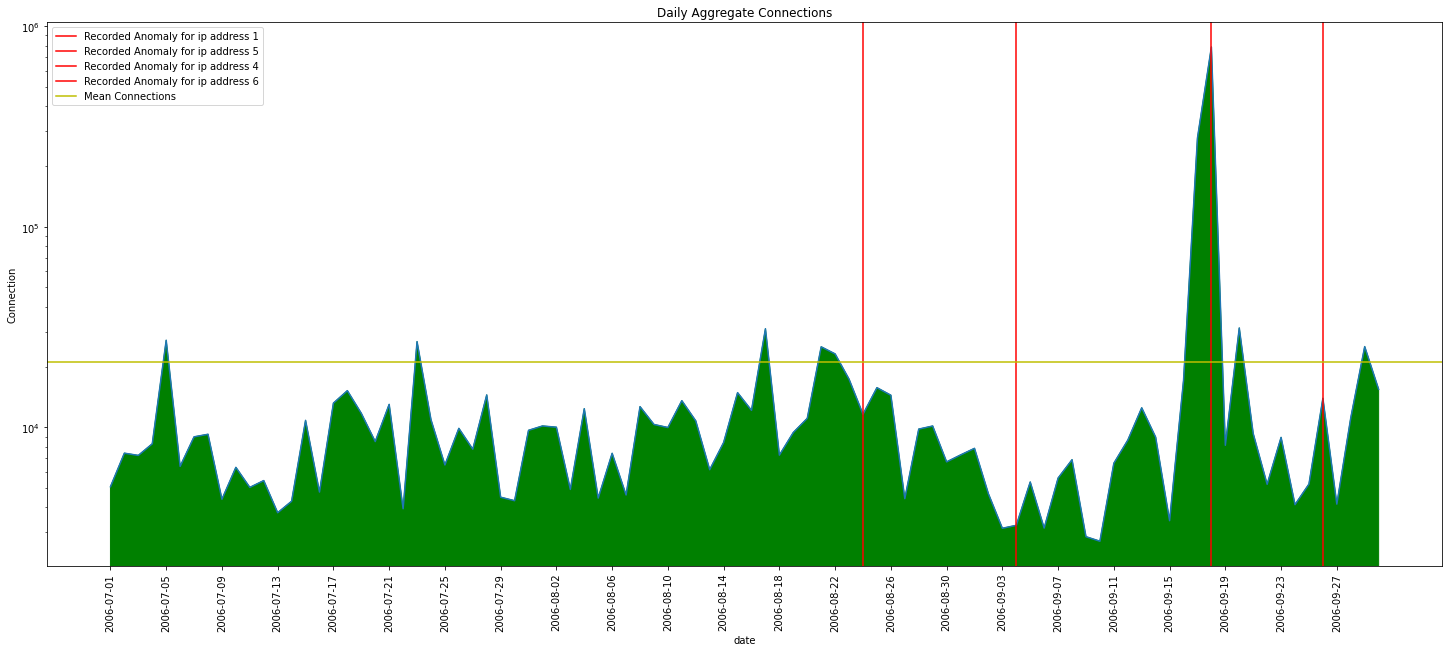

In [77]:
plt.figure(figsize=(25,10))
plt.plot(daily_aggregate['date'],daily_aggregate['f'])
[plt.axvline(x=_x, color='r' , label = 'Recorded Anomaly for ip address {}'.format(ip)) for _x,ip in list(marked_anomalies[['date','l_ipn']].to_records(index=False))]
plt.axhline(y= daily_mean, color='y', label = 'Mean Connections')

plt.xticks(daily_aggregate['date'][::4],  rotation='vertical')
plt.yscale('log')
plt.xlabel('date')
plt.ylabel('Connection')
plt.title('Daily Aggregate Connections')
plt.fill_between(daily_aggregate['date'],daily_aggregate['f'],color='green')
plt.legend()
plt.show()

In [78]:
daily_ip = df.groupby(['l_ipn','date'])[['f']].sum()
daily_ip.reset_index(inplace= True)

In [79]:
daily_ip[['f']].describe()

,f
count,847.000000
mean,2306.609209
std,28582.894686
min,4.000000
25%,60.000000
50%,346.000000
75%,1429.500000
max,785297.000000


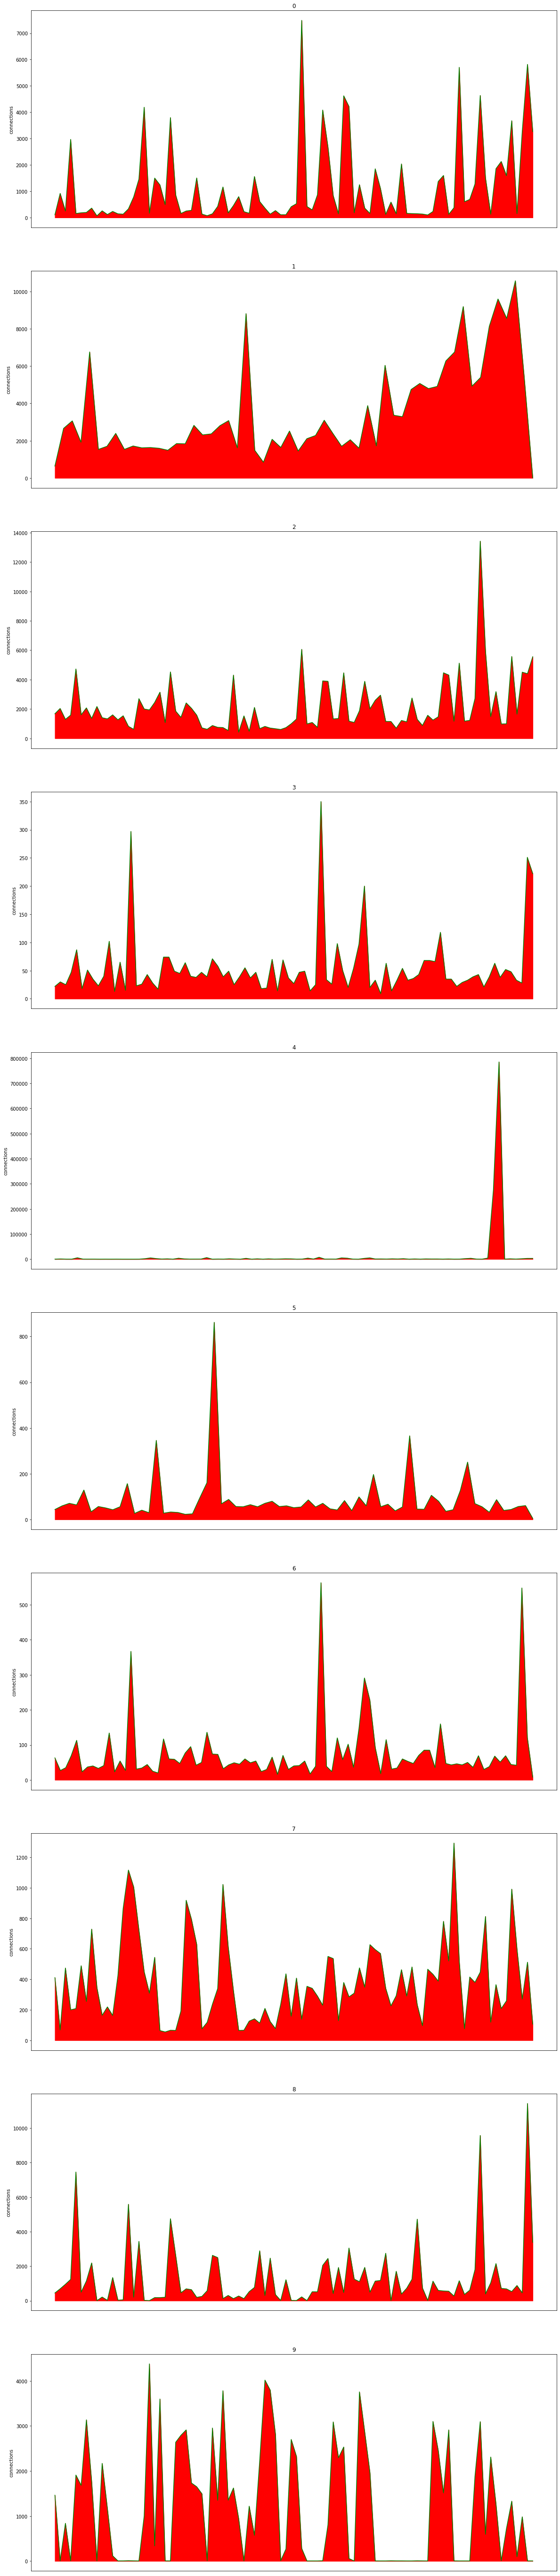

In [93]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(20, 100))

plot_row = 0


for i in range(df['l_ipn'].nunique()):
    temp = daily_ip[daily_ip['l_ipn'] == i]
    axes[plot_row].set_title(i)
    axes[plot_row].set_xlabel('date')
    axes[plot_row].set_ylabel('connections')
    
    axes[plot_row].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    axes[plot_row].plot(temp['date'],temp['f'], color = 'g')
    axes[plot_row].get_xaxis().set_visible(False)
    axes[plot_row].fill_between(temp['date'],temp['f'], color='r')

    plot_row = plot_row + 1
    

   
plt.show()

In [86]:
def get_daily_aggregate_l_ipn(in_l_ipn):
    temp_df = daily_ip[daily_ip['l_ipn'] == in_l_ipn].drop(['l_ipn'],axis = 1)
    temp_df.columns = ['ds','y']
    temp_df['ds'] = pd.to_datetime(temp_df['ds'])
    temp_df.reset_index(inplace=True,drop=True)
    return temp_df

In [82]:
pip install luminol

In [83]:
import luminol
from luminol.anomaly_detector import AnomalyDetector

In [84]:
def get_luminol_anomalies(ano):
    ano['isAnomaly'] = 0
    detector = AnomalyDetector(ano['y'].to_dict())
    anomalies = detector.get_anomalies()
    time_period = ()
    for j in range(len(anomalies)):
        time_period = anomalies[j].get_time_window()
        for k in time_period:
            ano.at[k,'isAnomaly'] = 1     
    return(ano)    

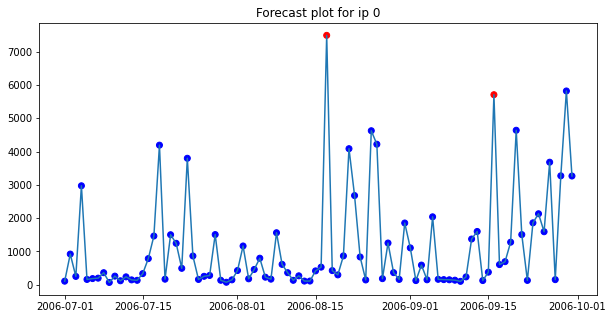

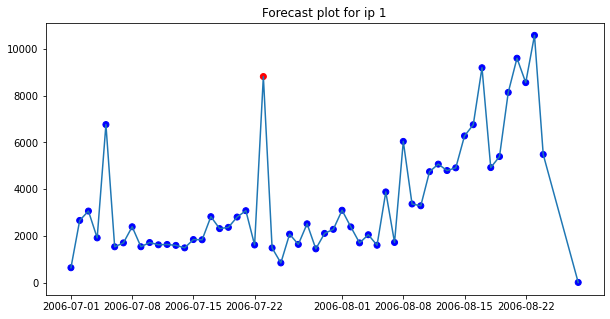

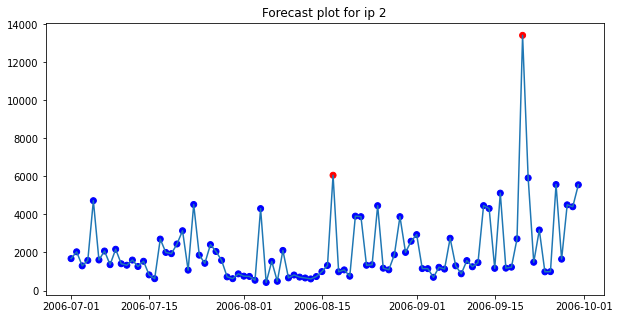

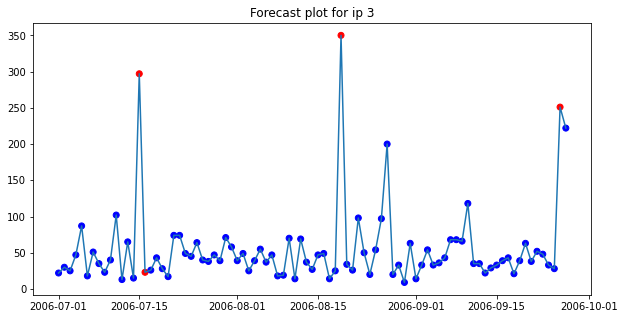

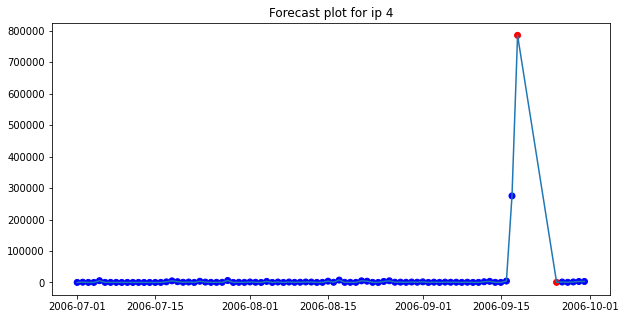

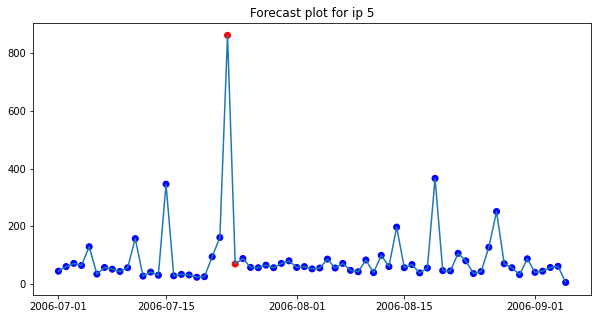

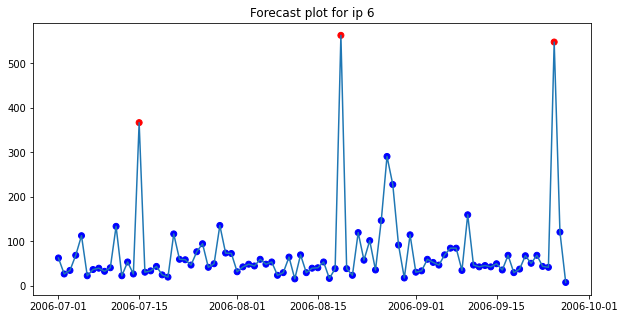

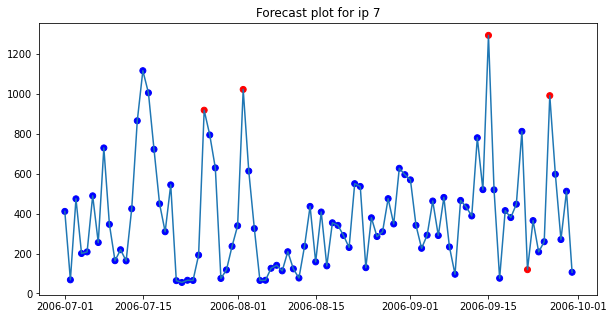

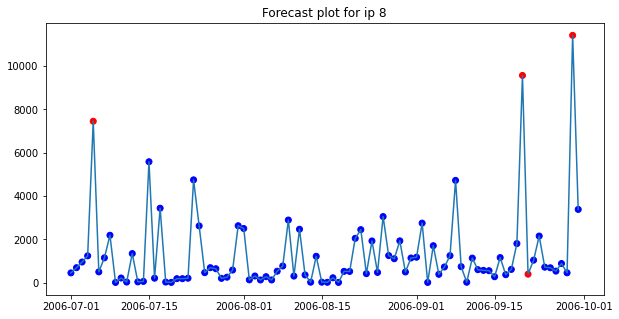

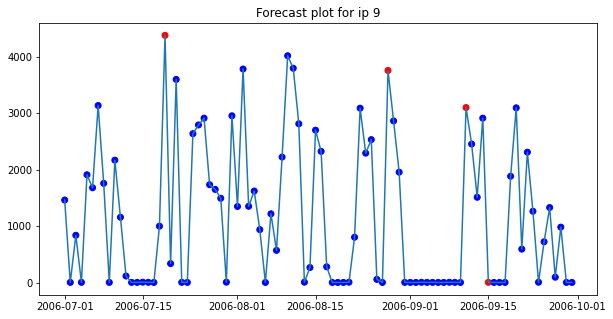

In [95]:
for i in range(df['l_ipn'].nunique()):
    t_df = get_luminol_anomalies(get_daily_aggregate_l_ipn(i))
    
    colors = {0:'blue', 1:'red'}
   
    plt.figure(figsize=(10,5))
    plt.plot(t_df['ds'],t_df['y'])
    plt.scatter(t_df['ds'],t_df['y'],c=t_df['isAnomaly'].apply(lambda x: colors[x]))
    plt.title('Forecast plot for ip %d' %i)
    plt.show()